                                 
 
 # Using Python to Access NEXRAD Level 2 Data &#x1F534;

> This notebook shows how to access the THREDDS Data Server (TDS) instance that is serving up archived NEXRAD Level 2 data hosted on NETCDF4. The TDS provides a mechanism to query for available data files, as well as provides access to the data as native volume files, through OPeNDAP, and using its own CDMRemote protocol. Since we're using Python, we can take advantage of Unidata's Siphon package, which provides an easy API for talking to THREDDS servers.
    
  

## The THREDDS DATA SERVER
<p> The THREDDS Data Server [TDS](https://www.unidata.ucar.edu/software/thredds/current/tds/TDS.html) is a web server that provides metadata and data access for scientific datasets, using OPeNDAP, OGC WMS and WCS, HTTP, and other remote data access protocols. The TDS is developed and supported by Unidata, a division of the University Corporation for Atmospheric Research (UCAR), and is sponsored by the National Science Foundation.<p/>

1. THREDDS Dataset Inventory Catalogs are used to provide virtual directories of available data and their associated metadata. These catalogs can be generated dynamically or statically.
2.  The Netcdf-Java/CDM library reads NetCDF, OpenDAP, and HDF5 datasets, as well as other binary formats such as GRIB and NEXRAD into a Common Data Model (CDM), essentially an (extended) netCDF view of the data. Datasets that can be read through the Netcdf-Java library are called CDM datasets.
3.  TDS can use the NetCDF Markup Language (NcML) to modify and create virtual aggregations of CDM datasets.
4. An integrated server provides OPeNDAP access to any CDM dataset. OPeNDAP is a widely used, subsetting data access method extending the HTTP protocol.

## Objectives:
 &#x1F539;Get introduced to using [Siphon](http://siphon.readthedocs.org) to talk to the THREDDS data server
  
&#x1F539; Learn how to open remote files on the data server using Python
    

 

# What you will need

1. [Install Miniconda (Python 2.7) from Continuum Analytics](http://conda.pydata.org/miniconda.html). ([Determine if your OS 32 or 64 bit](http://www.akaipro.com/kb/article/1616#os_32_or_64_bit).)
2. Once Miniconda is installed, from the command line (e.g., OS X terminal, cmd.exe), run these instructions:


- Once Miniconda is installed, you can use the conda command to install any other packages and create environments, etc. For example lets create an environment for this notebook:

```
conda create -n nexrad2 python=2 pip numpy scipy matplotlib netcdf4 scikit-learn scikit-image basemap netcdf 

```

### metpy and siphon installation

#### on unix

```
source activate workshop-metpy && pip install metpy siphon
```
#### on windows

```
activate workshop-metpy
pip install metpy siphon
```

### Py-ART

- [Py-ART documentation](http://arm-doe.github.io/pyart/)

- you can install Pyart using conda
```
conda install -c https://conda.anaconda.org/jjhelmus pyart
```

## Getting the data

> &#x1F538; Lets first navigate to http://thredds.ucar.edu/thredds/idd/radars.html where we will find a list of IDD radar data. 
  - We will be experimented with NEXRAD Level II Radar WSR-88D/	
      -The NEXRAD Level II feed from the IDD provides raw radar volume data collected from the NWS WSR-88Ds. Data are available approximately every 5 minutes in precipitation mode, and ten minutes in clear air mode

In [50]:
#importing all necessary modules
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 
from netCDF4 import Dataset
from siphon.radarserver import RadarServer, get_radarserver_datasets
import scipy.ndimage as spyi
import pyart
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

> ##### points to the top-level thredds radar server accessor to find what datasets are available.

In [51]:

ds = get_radarserver_datasets('http://thredds.ucar.edu/thredds/')
print("\n")
print(list(ds.keys()))
#show datasets at thredds data server 




['NEXRAD Level II Radar for Case Study CCS039', 'NEXRAD Level II Radar from IDD', 'NEXRAD Level III Radar for Case Study CCS039', 'NEXRAD Level III Radar from IDD', 'TDWR Level III Radar from IDD']


> ##### creates an instance of RadarServer to point to the appropriate radar server access URL. This is pulled from the catalog reference url. In this notebook we will work with Level 2 

In [52]:
url = ds['NEXRAD Level II Radar from IDD'].follow().catalog_url
rs = RadarServer(url)

In [53]:
#shows the variables of Level2 radar data
print(list(rs.variables))


['CorrelationCoefficient', 'SpectrumWidth', 'DifferentialReflectivity', 'Reflectivity', 'DifferentialPhase', 'Velocity']


- Weather Surveillance Radar–1988 Dopplers (**WSR–88Ds**) are used for overall weather surveillance and warnings by the National Weather Service, U. S. Air Force, and Federal Aviation Administration (FAA)

- A Doppler radar typically measures three base data parameters: **radar reflectivity** factor , mean **Doppler velocity** within the radar sampling volume and **spectrum width**. Interpretations of reflectivity and Doppler velocity data acquired from quasi-horizontal radar scans are based primarily on the identification of recognizable reflectivity and Doppler velocity patterns or "signatures."  

In [54]:

rs.stations

{'KABC': Station(id='KABC', elevation=49.0, latitude=60.78, longitude=-161.87, name='ANCHORAGE/Bethel'),
 'KABR': Station(id='KABR', elevation=397.0, latitude=45.45, longitude=-98.4, name='ABERDEEN/Aberdeen'),
 'KABX': Station(id='KABX', elevation=1789.0, latitude=35.13, longitude=-106.82, name='ALBUQUERQUE/Albuquerque'),
 'KACG': Station(id='KACG', elevation=63.0, latitude=56.85, longitude=-135.52, name='JUNEAU/Sitka'),
 'KAEC': Station(id='KAEC', elevation=16.0, latitude=64.5, longitude=-165.28, name='FAIRBANKS/Nome'),
 'KAHG': Station(id='KAHG', elevation=74.0, latitude=60.72, longitude=-151.35, name='ANCHORAGE/Nikiski'),
 'KAIH': Station(id='KAIH', elevation=20.0, latitude=59.45, longitude=-146.3, name='ANCHORAGE/Middleton_Island'),
 'KAKC': Station(id='KAKC', elevation=19.0, latitude=58.67, longitude=-156.62, name='ANCHORAGE/King_Salmon'),
 'KAKQ': Station(id='KAKQ', elevation=34.0, latitude=36.98, longitude=-77.0, name='WAKEFIELD/Wakefield'),
 'KAMA': Station(id='KAMA', elevation

>##### Create a new query object to help request the data. Using the chaining methods, ask for data from one of the radar FTG sites above for now. We see that when the query is represented as a string, it shows the encoded URL.

# TRY IT: Input a Station

In [55]:
query = rs.query()
query.stations('KBIS').time(datetime.utcnow()).variables('Reflectivity')

var=Reflectivity&time=2017-03-08T16%3A36%3A28.895049&stn=KBIS

>##### Make the request, which returns an instance of TDSCatalog. This handles parsing the catalog
>##### We can look at the datasets on the catalog to see what data we found by the query. We find one NIDS file in the return

In [56]:
catalog = rs.get_catalog(query)

In [57]:

catalog.datasets

OrderedDict([('Level2_KBIS_20170308_1626.ar2v',
              <siphon.catalog.Dataset at 0x1100934d0>)])

>###### We can pull that dataset out of the dictionary and look at the available access URLs. We see URLs for OPeNDAP, CDMRemote, and HTTPServer (direct download).



In [58]:
ds = list(catalog.datasets.values())[0]
ds.access_urls



{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/nexrad/level2/IDD/KBIS/20170308/Level2_KBIS_20170308_1626.ar2v',
 'HTTPServer': 'http://thredds.ucar.edu/thredds/fileServer/nexrad/level2/IDD/KBIS/20170308/Level2_KBIS_20170308_1626.ar2v',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/nexrad/level2/IDD/KBIS/20170308/Level2_KBIS_20170308_1626.ar2v'}

In [64]:


filename = ds.access_urls['OPENDAP']
#print(filename)

#reads nexrad data from opendap file 
radar = pyart.io.read_nexrad_cdm(filename)
radar.info()
#prints data of that file
print(radar)

#display = pyart.graph.RadarDisplay(radar)


altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	units: meters
	long_name: Altitude
	standard_name: Altitude
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (3960,)>
	comment: Azimuth of antenna relative to true north
	long_name: azimuth_angle_from_true_north
	standard_name: beam_azimuth_angle
	units: degrees
	axis: radial_azimuth_coordinate
elevation:
	data: <ndarray of type: float32 and shape: (3960,)>
	comment: Elevation of antenna relative to the horizontal plane
	long_name: elevation_angle_from_horizontal_plane
	standard_name: beam_elevation_angle
	units: degrees
	axis: radial_elevation_coordinate
fields:
	differential_phase:
		data: <ndarray of type: float32 and shape: (3960, 1832)>
		long_name: differential_phase_hv
		valid_min: 0.0
		_FillValue: -9999.0
		units: degrees
		valid_max: 360.0
		standard_name: differential_phase_hv
		coordinates: elevation azimuth range
	cross_correlation_ratio:
		data: <ndar

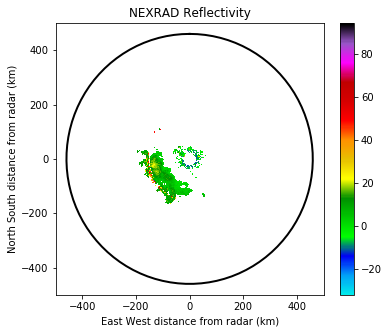

In [74]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
display.plot('reflectivity', 1, title='NEXRAD Reflectivity',
             vmin=-32, vmax=94.5, colorbar_label='', ax=ax)
display.plot_range_ring(radar.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-500, 500), ylim=(-500, 500), ax=ax)
plt.show()


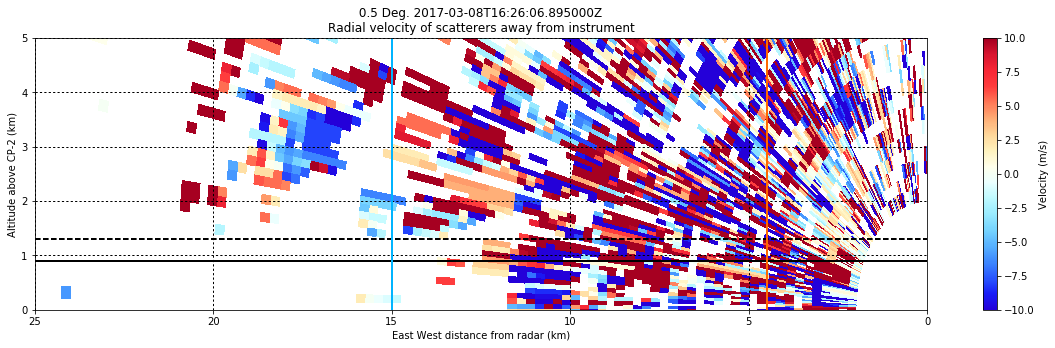

In [66]:
sweep=2
fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(111)
display.plot('velocity', 1, vmin=-10, vmax=10.0, fig=fig,
             ax=ax, cmap='pyart_BuDRd18', colorbar_label='Velocity (m/s)')
start = radar.get_start(sweep)
end = radar.get_end(sweep) + 1
data = radar.get_field(sweep, 'reflectivity')
x, y, z = radar.get_gate_x_y_z(sweep, edges=False)

x /= 1000.0
y /= 1000.0
z /= 1000.0
# smooth out the lines
data = spyi.gaussian_filter(data, sigma=1.2)

# calculate (R)ange
R = np.sqrt(x ** 2 + y ** 2) * np.sign(y)
R = -R
display.set_limits(xlim=[25, 0], ylim=[0, 5])

# add contours
# creates steps 35 to 100 by 5
levels = np.arange(35, 100, 5)
# adds coutours to plot
contours = ax.contour(R, z, data, levels, linewidths=1.5, colors='k',
                      linestyles='solid', antialiased=True)

# adds contour labels (fmt= '%r' displays 10.0 vs 10.0000)
plt.clabel(contours, levels, fmt='%r', inline=True, fontsize=10)


# add grid (dotted lines, major axis only)
ax.grid(color='k', linestyle=':', linewidth=1, which='major')


# horizontal
ax.axhline(0.9, 0, 1, linestyle='solid', color='k', linewidth=2)
ax.axhline(1.3, 0, 1, linestyle='dashed', color='k', linewidth=2)

# vertical
ax.axvline(15, 0, 1, linestyle='solid', color='#00b4ff', linewidth=2)
ax.axvline(4.5, 0, 1, linestyle='solid', color='#ff6800', linewidth=2)

# setting matplotlib overrides display.plot defaults
ax.set_ylabel('Altitude above CP-2 (km)')

plt.show()

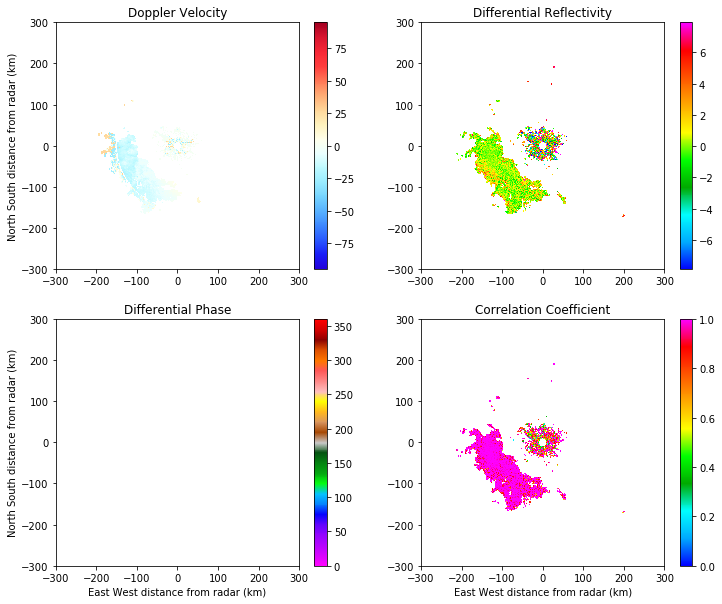

In [77]:
fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(221)
display.plot('velocity', 1, ax=ax, title='Doppler Velocity',
             colorbar_label='',
             axislabels=('', 'North South distance from radar (km)'))
display.set_limits((-300, 300), (-300, 300), ax=ax)

ax = fig.add_subplot(222)
display.plot('differential_reflectivity', 0, ax=ax,
             title='Differential Reflectivity', colorbar_label='',
             axislabels=('', ''))
display.set_limits((-300, 300), (-300, 300), ax=ax)

ax = fig.add_subplot(223)
display.plot('differential_phase', 0, ax=ax,
             title='Differential Phase', colorbar_label='')
display.set_limits((-300, 300), (-300, 300), ax=ax)

ax = fig.add_subplot(224)
display.plot('cross_correlation_ratio', 0, ax=ax,
             title='Correlation Coefficient', colorbar_label='',
             axislabels=('East West distance from radar (km)', ''))
display.set_limits((-300, 300), (-300, 300), ax=ax)

plt.show()

# DISPLAY THE LOWEST ELEVATION SCAN

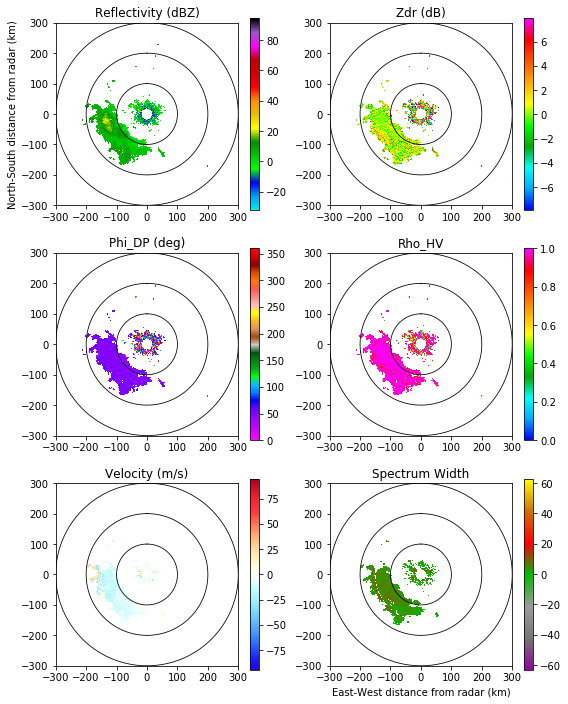

In [75]:
# display the lowest elevation scan data

radar = pyart.io.read_nexrad_cdm(filename)

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(9, 12))

plots = [
    # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
    ['reflectivity', 'Reflectivity (dBZ)', 0],
    ['differential_reflectivity', 'Zdr (dB)', 0],
    ['differential_phase', 'Phi_DP (deg)', 0],
    ['cross_correlation_ratio', 'Rho_HV', 0],
    ['velocity', 'Velocity (m/s)', 1],
    ['spectrum_width', 'Spectrum Width', 1]
]

def plot_radar_images(plots):
    ncols = 2
    nrows = len(plots)/2
    for plotno, plot in enumerate(plots, start=1):
        ax = fig.add_subplot(nrows, ncols, plotno)
        display.plot(plot[0], plot[2], ax=ax, title=plot[1],
             colorbar_label='',
             axislabels=('East-West distance from radar (km)' if plotno == 6 else '', 
                         'North-South distance from radar (km)' if plotno == 1 else ''))
        display.set_limits((-300, 300), (-300, 300), ax=ax)
        display.set_aspect_ratio('equal', ax=ax)
        display.plot_range_rings(range(100, 350, 100), lw=0.5, col='black', ax=ax)
    plt.show()

plot_radar_images(plots)